### Read data

In [1]:
import pandas as pd
import os
from fastai.text import *

data_folder = os.path.join(os.getcwd(), "data")
data_path = os.path.join(data_folder, "rspct.tsv")

In [2]:
df = pd.read_csv(data_path, sep = "\t")
df["text"] = df["selftext"].str[:512]

lm_df = (df
        .groupby("subreddit")
        .apply(lambda x: x.sample(frac=.2, random_state=1))
        .loc[:, "text"]
        .reset_index()
        )

lm_df.head(5)

,subreddit,level_1,text
0,13ReasonsWhy,515853,Spoilers spoilers!! <lb>To change the Title of...
1,13ReasonsWhy,824903,"For me, the two people who stand out to me as ..."
2,13ReasonsWhy,469637,"TV Shows, Movies, Theatre Shows, Art, even if ..."
3,13ReasonsWhy,375064,I thought I'd offer up a programme that talks ...
4,13ReasonsWhy,248728,Season 2 trailer: I have a theory that the per...


In [3]:
lm_df["text"][1]

'For me, the two people who stand out to me as characters whom I like more than in season 1 were Mr. Porter and Zach.<lb><lb>Mr. Porter went from a useless, emotionally distant person to a caring, uncompromising person willing to lose his job if it meant he protected the kids. Zach just finally chooses the right side. <lb><lb>On the flip side, my opinion of Hannah has been tarnished tremendously. <lb><lb>Thoughts? '

In [4]:
lm_df.shape

(202600, 3)

### Fine tune language model

In [5]:
bs = 64

In [6]:
data_lm = (TextList.from_df(lm_df, cols="text")
       .split_by_rand_pct(0.1)
       .label_for_lm()
       .databunch(bs=bs))

In [6]:
# data_lm.save(os.path.join(data_folder, "data_lm.pkl"))
data_lm = load_data(data_folder, "data_lm.pkl", bs=bs)

In [8]:
data_lm.show_batch()

idx,text
0,"deserved to know . xxmaj thought this would be a cool subtle message for the fans . :) < lb><lb > xxmaj what do you guys think ? xxbos xxmaj for me , the two people who stand out to me as characters whom i like more than in season 1 were xxmaj mr. xxmaj porter and xxmaj xxunk > xxmaj mr . xxmaj porter went from a useless ,"
1,"xxmaj ai on my imac and its great . xxmaj however i m looking for a tablet ( with a pen ) that i can take on the go , and use while i 'm out and about and then finish my work on the imac when i 'm home . xxmaj but also looking at a tablet with a pen so i have more control . ( to clarify"
2,"soun xxbos i took my dog to the vet and he said that my dog had an ear infection which has cleared up after the antibiotics but he also said that he has allergies which was causing inflammation in his paws , dandruff near his back above the tail and what you see around his eyes . xxmaj currently he 's on allergy medication but it does nt seem to"
3,"move ? xxmaj like if those were bed bugs , they 'd b xxbos i just found a bed bug in my apartment and i quickly reported it to my landlord . xxmaj apparently our lease states that bed bug infestations are the tenant 's responsibility . ( xxmaj edit : https : / / imgur.com / xxunk > xxmaj but this is a row of townhouse - like units"
4,me if i have any allergies . i said “ well it ’s not an allergy but gluten . ” xxmaj she seemed confused so i tell her “ i have celiac disease ” . i get a blank stare . “ … so i ca n’t take anything with gluten in it ” . xxmaj the technician then laughs at me and tells me in a xxbos xxmaj observation


In [9]:
lm_learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
lm_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


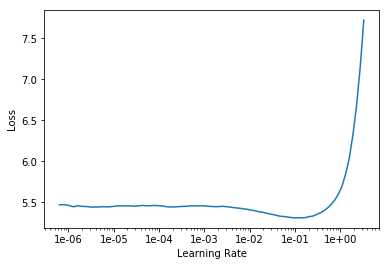

In [10]:
lm_learn.recorder.plot()

In [11]:
lm_learn.fit_one_cycle(3, 7e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.178874,4.967162,0.216591,33:28
1,4.855431,4.655824,0.240839,33:36
2,4.469001,4.312628,0.262793,33:37


In [10]:
# lm_learn.save("lm_fine_tuned")
lm_learn.load("lm_fine_tuned")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (182340 items)
x: LMTextList
xxbos xxmaj spoilers spoilers ! ! < lb > xxmaj to change the xxmaj title of the subreddit from 13 xxmaj reasons xxmaj why to 12 xxmaj reasons xxmaj why when you hover your mouse over it ? < lb><lb > * xxmaj reason : xxmaj clay was not one of those reasons and xxmaj hannah does say that he should n't be on those tapes but that he just deserved to know . xxmaj thought this would be a cool subtle message for the fans . :) < lb><lb > xxmaj what do you guys think ?,xxbos xxmaj for me , the two people who stand out to me as characters whom i like more than in season 1 were xxmaj mr. xxmaj porter and xxmaj xxunk > xxmaj mr . xxmaj porter went from a useless , emotionally distant person to a caring , xxunk person willing to lose his job if it meant he protected the kids . xxmaj zach just finally chooses the right side . < lb><lb > xxmaj on the flip side , my opinion of xxmaj hannah has been tarnished tremendou

In [11]:
lm_learn.unfreeze()
lm_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


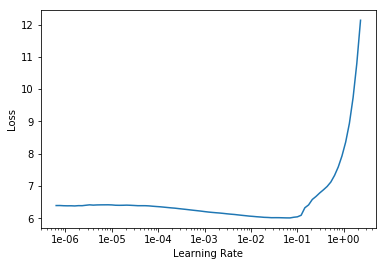

In [12]:
lm_learn.recorder.plot()

In [13]:
lm_learn.fit_one_cycle(7, 1e-02, moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,4.364845,4.286258,0.275972,37:55
1,4.257897,4.179180,0.279918,37:59
2,4.165173,4.083360,0.288272,38:01
3,4.046122,3.996440,0.295953,38:03
4,3.926351,3.903427,0.304501,38:06
5,3.786420,3.837030,0.310937,38:09
6,3.678897,3.825603,0.312430,38:08


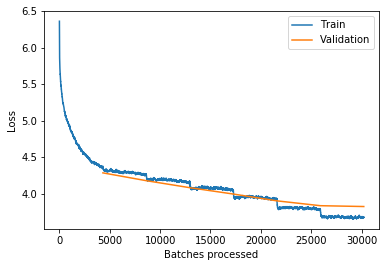

In [14]:
lm_learn.recorder.plot_losses()

In [15]:
lm_learn.save("lm_fine_tuned")
# lm_learn.load("lm_fine_tuned")

In [16]:
lm_learn.save_encoder("lm_encoders")

### Fit classifier

In [5]:
bs = 64
nrows = df.shape[0]
init_range = int(nrows*0.8)

In [6]:
valid_idx = list(range(init_range, nrows))
train_idx = (df
        .loc[:init_range]
        .groupby("subreddit")
        .apply(lambda x: x.sample(frac=.5, random_state=1))
        .loc[:, "text"]
        .reset_index()
        .loc[:, "level_1"].tolist()
        )

In [7]:
len(valid_idx)

202600

In [8]:
len(train_idx)

405200

In [21]:
data_class = (TextList.from_df(df, cols="text", vocab=data_lm.vocab)
             .split_by_idxs(train_idx, valid_idx)
             .label_from_df("subreddit")
             .databunch(bs=bs)
             )

In [9]:
# data_class.save(os.path.join(data_folder, "data_class.pkl"))
data_class = load_data(data_folder, "data_class.pkl", bs=bs)

In [10]:
data_class.show_batch()

text,target
xxbos 👉 xxup every 🅾 xxup xxunk 👨 ‍ 👩 ‍ 👧 ‍ 👦 xxup has 🅰 ️ 👏 xxup xxunk 👏 xxup in xxup their 👈 h 🅾 xxup xxunk 🏡 . xxup first 👆 xxup they xxunk xxup take 👈 xxup the 🍌 🍆 xxup xxunk 🍆 🅱 ️ 🅾 xxup xxunk xxunk 🅰 xxup xxunk 🌚 xxup they 💦 xxup sm 🅾 ️ 🅾 xxup xxunk 💦,emojipasta
xxbos 🎃 xxup trick xxup or xxup treat 🎃 < lb > xxunk xxunk xxup smell xxup my xxup feet xxunk < lb > xxunk 👻 xxup gimme xxup some xxunk < lb > xxup good xxup dick xxup to xxup eat 👻 < lb><lb > xxup surprise xxup bitch xxup you've xxup now xxup been xxup cursed xxup with xxup the 👹 🙅 xxup xxunk 🙅 👹,emojipasta
xxbos * * xxmaj method xxmaj xxunk > xxmaj spread | xxmaj pick | xxmaj win / xxmaj loss < lb>---|---| xxrep 4 - < lb > xxup lar @ xxup xxunk + 3.5 | xxup lar | w < lb > xxup den @ xxup phi xxunk | xxup phi | w < lb > xxup cin @ xxup jax xxunk | xxup cin | l < lb >,DanLeBatardShow
"xxbos < xxunk xxmaj unbound xxmaj army ( xxmaj faction ) ( xxmaj imperium - xxup fw xxmaj adeptus xxmaj xxunk ) [ 4 xxup pl , xxunk ] + + * < lb><lb>**+ xxup hq + * * < xxunk xxmaj shen [ 4 xxup pl , xxunk xxmaj patrol xxmaj detachment ( xxmaj imperium - xxmaj space xxmaj marines ) [ 40 xxup pl , xxunk ] +",WarhammerCompetitive
xxbos xxunk xxunk > i have been studying xxmaj korean for about a year now but i still do not grasp the pattern of ' xxunk / xxunk xxunk / xxunk ' and their xxunk > xxmaj correct me if i am wrong at the following part : > < lb><lb > xxmaj usage of:<lb><lb > * ' xxunk / xxunk xxunk ' - xxmaj person a does x for,Korean


In [11]:
acc = partial(accuracy)
acc_3 = partial(top_k_accuracy, k=3)
acc_5 = partial(top_k_accuracy, k=5)

In [12]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.25, metrics=[acc, acc_3, acc_5])

In [10]:
learn.load_encoder(os.path.join(os.getcwd(), "models", "lm_encoders"))

RNNLearner(data=TextClasDataBunch;

Train: LabelList (405200 items)
x: TextList
xxbos xxmaj so the end of the show sets up some obvious story arcs for season two but i have a few theories of my own , some based off of what i have seen online and some of my own . < lb><lb > xxmaj xxunk i think he is going to survive but in a heavily problematic way ( xxunk state , speech problems , paralysis , something like that ) in order to continue addressing suicide but from a new perspective since with xxmaj hannah we saw the affects of a successful suicide . xxmaj from the beginning i thought he seemed like a candidate for suicide,xxbos for me it was justin foley as he was such a complex character . i loved how i was able to xxunk with him as the series progressed and showed more of his inner nature < lb > the actor did a great job xxunk emotion into his lines and facial expressions < lb > he was able to convey these feelings through his eyes and i really felt that in the scenes with jess and cla

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


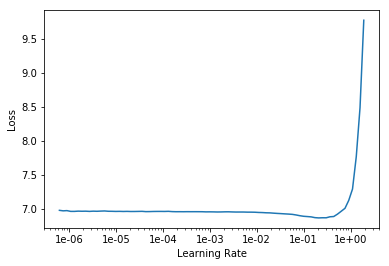

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, 1e-01, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,4.796091,4.690875,0.100424,0.205390,0.276372,18:11
1,4.106991,3.859857,0.184753,0.337957,0.428430,18:36
2,3.376474,3.004184,0.342502,0.524936,0.609112,18:29


In [13]:
# learn.save("classifier")
learn.load("classifier")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (405200 items)
x: TextList
xxbos xxmaj so the end of the show sets up some obvious story arcs for season two but i have a few theories of my own , some based off of what i have seen online and some of my own . < lb><lb > xxmaj xxunk i think he is going to survive but in a heavily problematic way ( xxunk state , speech problems , paralysis , something like that ) in order to continue addressing suicide but from a new perspective since with xxmaj hannah we saw the affects of a successful suicide . xxmaj from the beginning i thought he seemed like a candidate for suicide,xxbos for me it was justin foley as he was such a complex character . i loved how i was able to xxunk with him as the series progressed and showed more of his inner nature < lb > the actor did a great job xxunk emotion into his lines and facial expressions < lb > he was able to convey these feelings through his eyes and i really felt that in the scenes with jess and cla

In [14]:
# learn.freeze_to(-3)
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


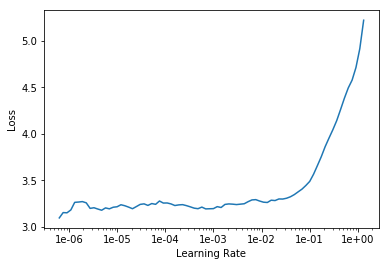

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, 7e-04, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.521589,2.150539,0.536737,0.691767,0.751249,43:23
1,2.044085,1.775450,0.624191,0.754141,0.800874,42:14
2,1.862273,1.711112,0.636530,0.764023,0.809398,44:11


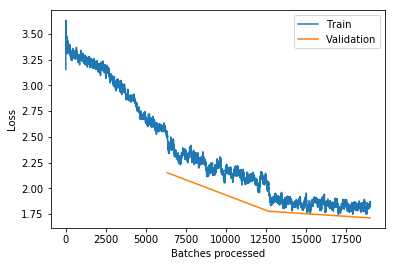

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save("classifier")